##### Esboço para a analise



Utilizando modelo de black scholes e calculando a vol implicita de mercado minimizando a MQO ponderada temos

A idéia então é minimizar o erro quadrático médio do mercado e encontrar essas duas váriaveis

c:\Users\diogo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\diogo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,Under,Strike,Venc,Tipo,Preço,Volume,Black-Scholes
0,AAAA3,25,365,Call,77.022029,260800,77.827714
1,AAAA3,26,365,Call,77.556945,274000,76.940793
2,AAAA3,27,365,Call,77.339647,282500,76.053873
3,AAAA3,28,365,Call,74.264279,297700,75.166952
4,AAAA3,29,365,Call,75.016137,302400,74.280032
...,...,...,...,...,...,...,...
145,AAAA3,170,365,Call,0.589886,298500,0.003286
146,AAAA3,171,365,Call,2.364003,292400,0.002787
147,AAAA3,172,365,Call,0.120545,281300,0.002361
148,AAAA3,173,365,Call,1.111372,282300,0.001999


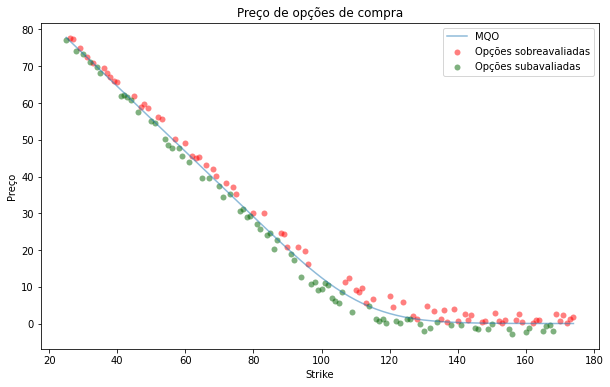

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import sys
import warnings
import yfinance as yf
from scipy import stats
import risk_functions as rf
from scipy.optimize import minimize
import black_scholes as bs
from IPython.display import display, HTML,clear_output
np.set_printoptions(suppress=True, precision=8)
### abrrir o arquivo  options.csv

opcs = pd.read_csv('opcs.csv', encoding='ANSI')



teste = opcs.sample(150)

X = teste['Strike'].values
Y = teste['Preço'].values
weight = teste['Volume'].values / teste['Volume'].sum()


price = 100
r = 0.12
maturity = 1

def error(params):
    sigma, add_price = params
    call_modelo = bs.bs_call(price+add_price,teste['Strike'].values, maturity, r, sigma)
    mqo = (Y - call_modelo)**2
    mqo = (mqo * weight).mean()

    return mqo

targuet = [.9,0.0]

resultado = minimize(error, targuet, method='Nelder-Mead')
sigma, add_price = resultado.x

## Teste

X = opcs['Strike'].values
Y = opcs['Preço'].values


call_modelo = bs.bs_call(price+add_price, X, maturity, r, sigma)

Z = Y > call_modelo

# force figsize 10,6

plt.figure(figsize=(10,6))
plt.plot(X, call_modelo, label='MQO', alpha = 0.5)
# Nomear os eixos e o titulo

plt.xlabel('Strike')
plt.ylabel('Preço')
plt.title('Preço de opções de compra')
sns.scatterplot(X[Z], Y[Z], label='Opções sobreavaliadas', linewidth=0, alpha=0.5, color='red')
sns.scatterplot(X[~Z], Y[~Z], label='Opções subavaliadas', linewidth=0, alpha=0.5, color='darkgreen')



opcs['Black-Scholes'] = call_modelo

opcs 


In [2]:
opcs['Delta'] = bs.bs_call_delta(100,opcs['Strike'],1,0.05,sigma)
opcs['Gamma'] = bs.bs_call_gamma(100,opcs['Strike'],1,0.05,sigma)
opcs['Vega'] = bs.bs_call_vega(100,opcs['Strike'],1,0.05,sigma)
opcs['Theta'] = bs.bs_call_theta(100,opcs['Strike'],1,0.05,sigma)
opcs['Rho'] = bs.bs_call_rho(100,opcs['Strike'],1,0.05,sigma)
opcs['Trade'] = opcs['Preço'] < opcs['Black-Scholes']
opcs['Trade'] = opcs['Trade'].map({True: 'Buy', False: 'Sell'})
opcs['Code'] = opcs['Under'] + '-' + opcs['Strike'].apply(str)
opcs['Weight'] = 0


In [3]:
## Como estamos trabalhando apenas com call, o sinal é importante, mas futuramente em estrutura mista com call/put comprada/vendida, o delta  pode ser muito útil :) 

# Filtrar as opções compradas
opcs_compradas = opcs[opcs['Trade'] == 'Buy']
opcs_vendidas = opcs[opcs['Trade'] == 'Sell']

# Inicializar o dicionário
df_estruturas = pd.DataFrame(columns=['Buy','Sell', 'Return','Delta', 'Gamma', 'Vega', 'Theta', 'Rho'])

# Iterar sobre as opções compradas
for index, opcao_comprada in opcs_compradas.iterrows():
    strike_comprada = opcao_comprada['Strike']
    vencimento_comprada = opcao_comprada['Venc']
    codigo_comprada = opcao_comprada['Code']
    
    #Most similar option
    opcoes_vendidas_filtradas = opcs_vendidas.sort_values(by=['Strike'], key= lambda x: abs(x - strike_comprada))
    opcao_vendida = opcoes_vendidas_filtradas.iloc[0]
    codigo_vendida_proxima = opcoes_vendidas_filtradas['Code'].values[0]
    
    # Adicionar a opção comprada e a vendida mais próxima ao dicionário

    buy_i = opcao_comprada['Code']
    sell_i = codigo_vendida_proxima
    return_comprada_i = opcao_comprada['Black-Scholes'] - opcao_comprada['Preço']
    return_vendida_i =  opcao_vendida['Preço'] - opcao_vendida['Black-Scholes']
    return_i = return_comprada_i + return_vendida_i
    delta_i = opcao_comprada['Delta'] - opcao_vendida['Delta']
    gamma_i = opcao_comprada['Gamma'] - opcao_vendida['Gamma']
    vega_i = opcao_comprada['Vega'] - opcao_vendida['Vega']
    theta_i = opcao_comprada['Theta'] - opcao_vendida['Theta']
    rho_i = opcao_comprada['Rho'] - opcao_vendida['Rho']

    df_estruturas = df_estruturas.append({'Buy': buy_i, 'Sell': sell_i, 'Return': return_i, 'Delta': delta_i, 'Gamma': gamma_i, 'Vega': vega_i, 'Theta': theta_i, 'Rho': rho_i}, ignore_index=True)

clear_output()


# Selecionar o primeiro quartil relevante
tam = len(df_estruturas)
df_estruturas = df_estruturas.sort_values(by=['Return'], ascending=False)[:int(tam/4)]
df_estruturas


,Buy,Sell,Return,Delta,Gamma,Vega,Theta,Rho
52,AAAA3-119,AAAA3-120,7.625472,0.01681,0.001199,1.55351,-0.177723,1.542169
36,AAAA3-94,AAAA3-93,7.415637,-0.020583,0.00154,1.994904,-0.064312,-1.297801
51,AAAA3-118,AAAA3-120,6.962218,0.034772,0.002391,3.096935,-0.35982,3.184875
58,AAAA3-130,AAAA3-131,6.912975,0.006518,0.000807,1.045443,-0.098328,0.612376
44,AAAA3-104,AAAA3-107,6.86017,0.087346,-0.000257,-0.332423,-0.349068,7.411964
45,AAAA3-105,AAAA3-107,6.697616,0.058061,-0.000006,-0.007377,-0.247125,4.952048
43,AAAA3-103,AAAA3-107,6.64904,0.116591,-0.000675,-0.87401,-0.435378,9.839683
47,AAAA3-109,AAAA3-110,6.373468,0.027258,0.000525,0.680563,-0.163613,2.390712
32,AAAA3-86,AAAA3-88,6.099865,0.022125,-0.0026,-3.36836,0.194894,0.465229
59,AAAA3-132,AAAA3-131,6.021998,-0.005875,-0.000754,-0.976901,0.090909,-0.552782


In [4]:
matriz_a = df_estruturas[['Delta','Gamma','Vega','Theta','Rho']].astype(float).to_numpy().T


# Calcula a SVD da matriz
U, S, V = np.linalg.svd(matriz_a)

# Índices das colunas cujos vetores formam o espaço nulo
restrict = 1e-10
tamanho = 0
while tamanho < 2:
    restrict = restrict * 2
    null_indices = np.where(S < 5e-10)[0]
    tamanho = len(null_indices.T)

# Vetores que formam o espaço nulo
null_vectors = V.T[:, null_indices]

vetores_espaco_nulo = []

for vetor in null_vectors.T:
    normalize = df_estruturas['Return'].dot(vetor)
    vetor = 10 * vetor / normalize
    vetores_espaco_nulo.append(vetor.tolist())

null_vectors = np.array(vetores_espaco_nulo).T

# Função objetivo para a função minimizadora de risco (O mínimo de concentração)

def funcao_objetivo_min_risk(x, null_vectors=null_vectors):
    # Produto do vetor X com a base null_vectors
    weight_final = np.dot(x, null_vectors.T)

    return weight_final.std()

# Função de restrição para garantir que os elementos sejam positivos e somem 1
def constraint(x):
    return np.sum(x) - 1


# Restrição de que cada elemento deve ser maior que 0
constraints = [{'type': 'ineq', 'fun': lambda x: x[i]} for i in range(tamanho)]

constraint_eq = {'type': 'eq', 'fun': lambda x: np.sum(x) -1}

# Vetor inicial de tamanho N com valores positivos
x0 = np.ones(tamanho)

# Chamada para a função minimize
result = minimize(funcao_objetivo_min_risk, x0, constraints=[constraint_eq] + constraints)

# Vetor de solução
solucao = result.x / np.sum(result.x)  # Normalizando para garantir soma igual a 1


In [5]:
df_estruturas['Weight'] = np.dot(solucao, null_vectors.T)

for i,row in df_estruturas.iterrows():
    
    opc_buy = row['Buy']
    opc_sell = row['Sell']

    opcs.loc[opcs['Code'] == opc_buy, 'Weight'] = row['Weight']
    opcs.loc[opcs['Code'] == opc_sell, 'Weight'] = -row['Weight']


opcs[opcs['Weight'] != 0]


,Under,Strike,Venc,Tipo,Preço,Volume,Black-Scholes,Delta,Gamma,Vega,Theta,Rho,Trade,Code,Weight
46,AAAA3,71,365,Call,34.456269,272400,37.029826,0.999015,0.000256,0.331958,-3.393258,67.435175,Buy,AAAA3-71,-0.008095
47,AAAA3,72,365,Call,38.334410,273800,36.143154,0.998591,0.000356,0.460975,-3.446966,68.342215,Sell,AAAA3-72,0.008095
57,AAAA3,82,365,Call,25.775069,313800,27.298361,0.976307,0.004313,5.586895,-4.137393,75.511041,Buy,AAAA3-82,0.319344
58,AAAA3,83,365,Call,29.952807,327800,26.419855,0.970571,0.005170,6.696564,-4.226457,75.854940,Sell,AAAA3-83,-0.197110
59,AAAA3,84,365,Call,24.179559,337300,25.543691,0.963816,0.006130,7.940653,-4.318755,76.089403,Buy,AAAA3-84,0.197110
61,AAAA3,86,365,Call,20.364644,325300,23.800490,0.946860,0.008357,10.825423,-4.510437,76.186349,Buy,AAAA3-86,0.033589
63,AAAA3,88,365,Call,24.737727,303000,22.073707,0.924734,0.010958,14.193783,-4.705331,75.721120,Sell,AAAA3-88,-0.033589
68,AAAA3,93,365,Call,20.942282,324900,17.871931,0.843997,0.018474,23.930355,-5.136988,71.742272,Sell,AAAA3-93,-0.216113
69,AAAA3,94,365,Call,12.714015,330000,17.059301,0.823414,0.020015,25.925259,-5.201300,70.444471,Buy,AAAA3-94,0.216113
71,AAAA3,96,365,Call,16.092437,334900,15.470785,0.778138,0.022969,29.752547,-5.295395,67.368801,Sell,AAAA3-96,-0.121444


In [24]:
opcs['Under'].to_dict()

{0: 'AAAA3',
 1: 'AAAA3',
 2: 'AAAA3',
 3: 'AAAA3',
 4: 'AAAA3',
 5: 'AAAA3',
 6: 'AAAA3',
 7: 'AAAA3',
 8: 'AAAA3',
 9: 'AAAA3',
 10: 'AAAA3',
 11: 'AAAA3',
 12: 'AAAA3',
 13: 'AAAA3',
 14: 'AAAA3',
 15: 'AAAA3',
 16: 'AAAA3',
 17: 'AAAA3',
 18: 'AAAA3',
 19: 'AAAA3',
 20: 'AAAA3',
 21: 'AAAA3',
 22: 'AAAA3',
 23: 'AAAA3',
 24: 'AAAA3',
 25: 'AAAA3',
 26: 'AAAA3',
 27: 'AAAA3',
 28: 'AAAA3',
 29: 'AAAA3',
 30: 'AAAA3',
 31: 'AAAA3',
 32: 'AAAA3',
 33: 'AAAA3',
 34: 'AAAA3',
 35: 'AAAA3',
 36: 'AAAA3',
 37: 'AAAA3',
 38: 'AAAA3',
 39: 'AAAA3',
 40: 'AAAA3',
 41: 'AAAA3',
 42: 'AAAA3',
 43: 'AAAA3',
 44: 'AAAA3',
 45: 'AAAA3',
 46: 'AAAA3',
 47: 'AAAA3',
 48: 'AAAA3',
 49: 'AAAA3',
 50: 'AAAA3',
 51: 'AAAA3',
 52: 'AAAA3',
 53: 'AAAA3',
 54: 'AAAA3',
 55: 'AAAA3',
 56: 'AAAA3',
 57: 'AAAA3',
 58: 'AAAA3',
 59: 'AAAA3',
 60: 'AAAA3',
 61: 'AAAA3',
 62: 'AAAA3',
 63: 'AAAA3',
 64: 'AAAA3',
 65: 'AAAA3',
 66: 'AAAA3',
 67: 'AAAA3',
 68: 'AAAA3',
 69: 'AAAA3',
 70: 'AAAA3',
 71: 'AAAA3',
 7

In [51]:
# Criando uma economia artificial,
# com um ativo AAAA3 (com retorno médio r_ativo e vol_ativo (anualizada))
# uma taxa de juros 1Y de 15% (passeio aleatório com volatilidade r_j vol_j)
# assimetria de informação na vol sigma_assimetria


def simulator_econo(  tamanho = 365
                    , ativo_base = {'retorno':0.0,'vol':0.1}
                    , juros = {'inicial':.15,'retorno':.0,'vol':.05}
                    , opts = {'qnt' :10,'step':2,'vol_ass':.01}):
    
    #Create the dataframe
    econo_simulada = pd.DataFrame()
    
    # range of dates
    start_date  = pd.to_datetime('today').date()
    end_date    = start_date + pd.DateOffset(days=tamanho)
    

    econo_simulada['Date'] = pd.date_range(start=start_date, end=end_date,freq='D')
    econo_simulada['Date'] = pd.to_datetime(econo_simulada['Date'])
    econo_simulada['DailyReturn'] = 1 + np.random.normal(ativo_base['retorno'] , ativo_base['vol']/16,tamanho+1)
    econo_simulada['DailyRate'] = 1 + np.random.normal(juros['retorno'], juros['vol']/16,tamanho+1)
    econo_simulada['Ativo'] = econo_simulada['DailyReturn'].cumprod()*100
    econo_simulada['Juros'] = juros['inicial'] * econo_simulada['DailyRate'].cumprod()


    uplow = opts['qnt']*opts['step']
    opcs_simuladas = np.arange(100 - uplow, 101 + uplow, opts['step'])
    opcs_simuladas = pd.DataFrame(opcs_simuladas, columns=['Strike'])
    opcs_simuladas['Venc'] = end_date
    opcs_simuladas['Code'] = 'AAA3' + opcs_simuladas['Strike'].apply(str)
    
    opcs_simuladas['key'] = 1
    econo_simulada['key'] = 1

    opcs_simuladas_hist = pd.merge(opcs_simuladas,econo_simulada,on='key').drop('key',axis=1)

    n_opcs = len(opcs_simuladas_hist)

    opcs_simuladas_hist['ImpliedVol'] = ativo_base['vol'] * abs(np.random.normal(1,opts['vol_ass'],n_opcs))
    opcs_simuladas_hist['Volume'] = 1

    spot = opcs_simuladas_hist['Ativo']
    strike = opcs_simuladas_hist['Strike']
    venc = (opcs_simuladas_hist['Venc'] - opcs_simuladas_hist['Date']).dt.days / 365 
    rates = opcs_simuladas_hist['Juros']
    sigmas = opcs_simuladas_hist['ImpliedVol']

    opcs_simuladas_hist['Preço'] = bs.bs_call(spot,strike,venc,rates,sigmas)


    return opcs_simuladas_hist[['Date','Code','Strike','Venc','Ativo','Juros','Volume','Preço']]


# Estimador MQO para volatilidade 


#bs.bs_call(SPOT,STRIKE,TIME,RATE,SIGMA)

def vol_mqo(econ_sim):

    vol_mqo = dict()

    def error_generalist(implied_vol_estimation, spot, strike, maturity, r,volume,precos):

        sigma = implied_vol_estimation
        call_modelo = bs.bs_call(spot,strike,maturity, r, sigma)
        mqo = (precos - call_modelo)**2
        mqo = (mqo * volume).mean()

        return mqo


    for data_i in opcs_sim['Data'].unique():

        econ_sim_i = econ_sim[econ_sim.index == data_i]
        rate_i = econ_sim_i['Juros'].values[0]
        preco_i = econ_sim_i['Ativo'].values[0]

        
        opcs_sim_i = opcs_sim[opcs_sim['Data'] == data_i]

        strikes_i = opcs_sim_i['Strike'].values
        vencs_i = opcs_sim_i['Venc'].values
        volumes_i = opcs_sim_i['Volume'].values
        precos_i = opcs_sim_i['Preco'].values


        error = lambda x: error_generalist(x, preco_i, strikes_i, vencs_i, rate_i, volumes_i,precos_i)

        targuet = 0.01
        bounds = [(0.0001, 0.5)]
        result = minimize(error, targuet, method='Nelder-Mead', bounds=bounds)

        vol_mqo[data_i] = result.x

    return vol_mqo  
        

        







econ_sim = simulator_econo()

In [52]:
econ_sim

,Date,Code,Strike,Venc,Ativo,Juros,Volume,Preço
0,2023-08-09,AAA380,80,2024-08-08,100.541416,0.150430,1,3.171448e+01
1,2023-08-10,AAA380,80,2024-08-08,99.652250,0.150379,1,3.079361e+01
2,2023-08-11,AAA380,80,2024-08-08,101.110083,0.149177,1,3.214047e+01
3,2023-08-12,AAA380,80,2024-08-08,102.446648,0.148746,1,3.341935e+01
4,2023-08-13,AAA380,80,2024-08-08,102.134946,0.150067,1,3.316969e+01
...,...,...,...,...,...,...,...,...
7681,2024-08-04,AAA3120,120,2024-08-08,83.009918,0.149587,1,1.046562e-263
7682,2024-08-05,AAA3120,120,2024-08-08,83.231197,0.149249,1,0.000000e+00
7683,2024-08-06,AAA3120,120,2024-08-08,84.139900,0.149028,1,0.000000e+00
7684,2024-08-07,AAA3120,120,2024-08-08,84.717240,0.148706,1,0.000000e+00


In [10]:
vols = vol_mqo(opts_sim,econ_sim)

c:\Users\diogo\OneDrive\Área de Trabalho\faculdade\Itau asset\overnightStrategy\black_scholes.py:24: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))


In [16]:
vols = pd.DataFrame(vols.items(),columns=['Data','Vol_mqo'])

In [17]:
vols

,Data,Vol_mqo
0,2023-08-09,0.080688
1,2023-08-10,0.096063
2,2023-08-11,0.071000
3,2023-08-12,0.104563
4,2023-08-13,0.102938
...,...,...
360,2024-08-03,0.102188
361,2024-08-04,0.010000
362,2024-08-05,0.010000
363,2024-08-06,0.010000


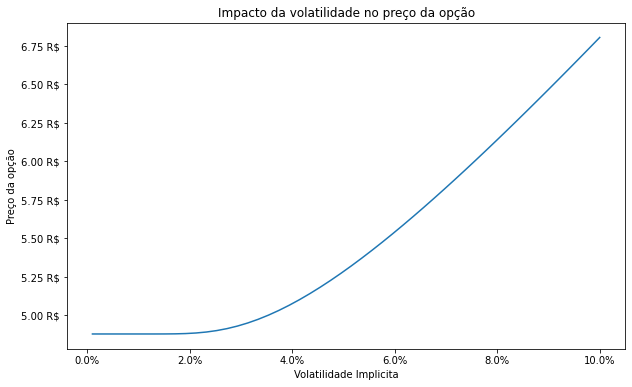

In [8]:
sigmas= np.linspace(0.001, .1, 50)


#Plotar um gráfico que mostra o impacto da volatilidade no preço da opção
plt.figure(figsize=(10,6))
plt.title('Impacto da volatilidade no preço da opção')
plt.xlabel('Volatilidade Implicita')
plt.ylabel('Preço da opção')
plt.plot(sigmas,bs.bs_call(100, 100, 1, 0.05, sigmas))
# Arrumar ticker do eixo Y (moeda R$)
# Arrumar ticker do eixo X (vol %)
ticker = mtick.StrMethodFormatter('{x:,.2f} R$')
plt.gca().yaxis.set_major_formatter(ticker)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
# Eixo X logaritmico

plt.show()
